In [ ]:
!pip install geopandas
!pip install contextily
!pip install mapclassify
!pip install geojson
!pip install branca

In [1]:
import geopandas
import contextily as cx
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon, box
import folium
from branca.element import Figure
import geojson

ModuleNotFoundError: No module named 'geopandas'

In [3]:
data = pd.read_csv('data/yellow_tripdata_2016-05.csv', index_col=0)
regions = pd.read_csv('data/regions.csv', sep=';')

# Задание 1

In [221]:
#Количество ячеек из которых в мае не было совершено ни одной поездки
(data.sum(axis=0) == 0).sum()

1283

# Задание 2

Эмпайр Стэйт Билдинг находится в 1231-ом регионе

In [7]:
regions.loc[1230]

region    1231.000000
west       -73.988912
east       -73.977800
south       40.747766
north       40.756154
Name: 1230, dtype: float64

In [8]:
esb = pd.DataFrame({'title': ['Empire State Building'], 'latitude': [-73.985428], 'longitude': [40.748817]})
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(esb['latitude'], esb['longitude'])]
# create GeoPandas dataframe
esb = gpd.GeoDataFrame(esb,
 crs = {'init': 'epsg:4326'},
 geometry = geometry)
esb

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


title   latitude  longitude                    geometry
0  Empire State Building -73.985428  40.748817  POINT (-73.98543 40.74882)

In [9]:
df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
df_wm = df.to_crs(epsg=4326)

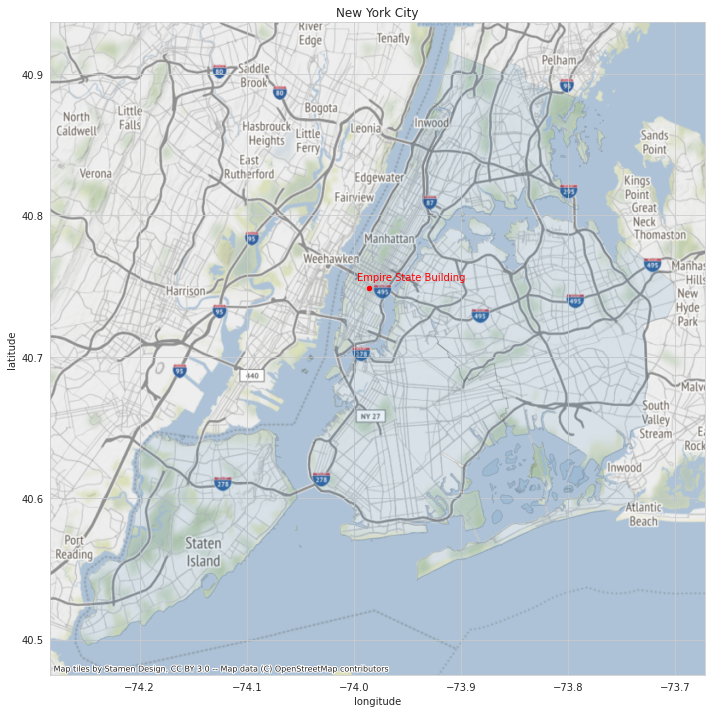

In [10]:
ax = df_wm.plot(figsize=(12,12), alpha=0.1, edgecolor='k')
cx.add_basemap(ax, alpha=0.8, crs=df_wm.crs)
esb.plot(markersize=20, color='red', ax=ax)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('New York City')

# Label the cities
for x, y, label in zip(esb['geometry'].x, esb['geometry'].y, esb['title']):
    ax.annotate(label, xy=(x,y), xytext=(-12,8), textcoords='offset points', color='red')

plt.show()

# Задание 3

In [11]:
def coord_to_pol(minx, miny, maxx, maxy):
  return box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

In [14]:
regions = pd.read_csv('regions.csv', sep=';')
rides=pd.DataFrame(data.sum(axis=0), columns=['taxi_rides'])
rides.index = pd.RangeIndex(start=1, stop=2501, name='region')
regions = pd.merge(rides, regions, on='region')
regions = gpd.GeoDataFrame(regions, geometry=regions.apply(lambda x: coord_to_pol(x['west'], x['south'], x['east'], x['north']), axis=1), crs=4326)
regions.head()

region  ...                                           geometry
0       1  ...  POLYGON ((-74.24448 40.49612, -74.24448 40.504...
1       2  ...  POLYGON ((-74.24448 40.50451, -74.24448 40.512...
2       3  ...  POLYGON ((-74.24448 40.51290, -74.24448 40.521...
3       4  ...  POLYGON ((-74.24448 40.52128, -74.24448 40.529...
4       5  ...  POLYGON ((-74.24448 40.52967, -74.24448 40.538...

[5 rows x 7 columns]

In [15]:
grid_intersect = pd.DataFrame({
    'Staten Island': regions.geometry.intersects(df_wm.iloc[0,-1]),
    'Queens' : regions.geometry.intersects(df_wm.iloc[1,-1]),
    'Brooklyn' : regions.geometry.intersects(df_wm.iloc[2,-1]),  
    'Manhattan' : regions.geometry.intersects(df_wm.iloc[3,-1]),  
    'Bronx' : regions.geometry.intersects(df_wm.iloc[4,-1]),            
              })
regions_in_bounds = regions[grid_intersect.any(axis=1)]

## Визуализация данных о поездо до удаления ячеек вне Нью-Йорка

/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 9
  Warn("Warning: setting k to %d" % k_q, UserWarning)


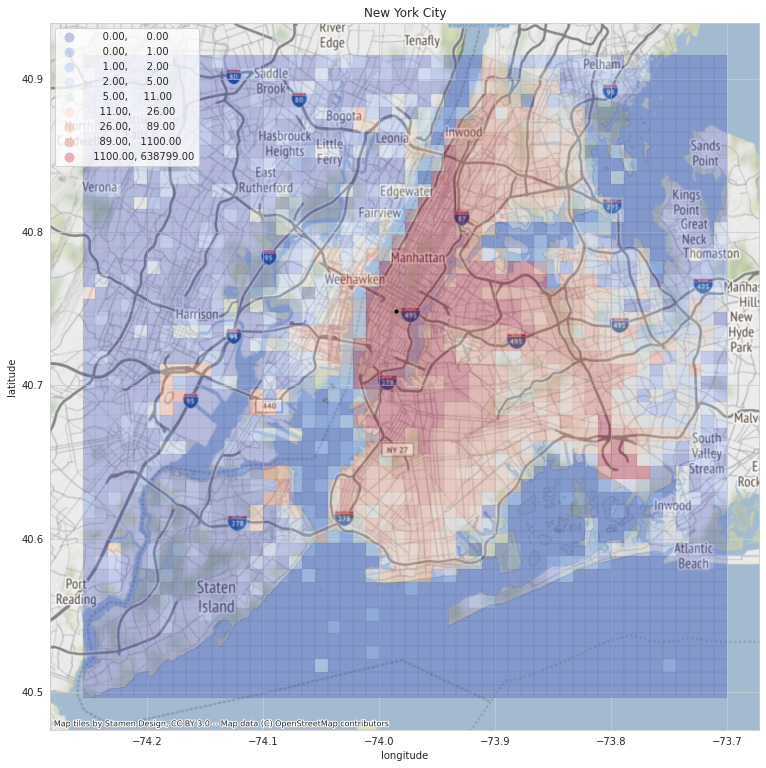

In [16]:
ax = df_wm.plot(figsize=(20,13), alpha=0.1, color='grey', edgecolor='k')
regions.plot(alpha=0.3, edgecolor='black', column='taxi_rides', scheme='Quantiles', k=17,
                       cmap='coolwarm', linewidth=0.1, 
                       legend=True, legend_kwds={'loc': 'upper left'},
                       ax=ax)

cx.add_basemap(ax, alpha=0.9, crs=df_wm.crs)
esb.plot(markersize=10, color='black', ax=ax)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('New York City')

plt.show()

## Визуализация данных о поездо после удаления ячеек по Нью-Йорка

In [17]:
ax = df_wm.plot(figsize=(20,13), alpha=0.1, color='grey', edgecolor='k')
regions_in_bounds.plot(alpha=0.3, edgecolor='black', column='taxi_rides', scheme='Quantiles', k=17,
                       cmap='coolwarm', linewidth=0.1, 
                       legend=True, legend_kwds={'loc': 'upper left'},
                       ax=ax)

cx.add_basemap(ax, alpha=0.9, crs=df_wm.crs)
esb.plot(markersize=10, color='black', ax=ax)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('New York City')

plt.show()

/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 13
  Warn("Warning: setting k to %d" % k_q, UserWarning)


# Задание 4

Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

In [53]:


map = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap',
 zoom_start=11)

folium.Marker(location=[40.689247,-74.044502], popup = "Statue of Liberty").add_to(map)
fig=Figure(width=1100,height=500)
fig.add_child(map)

map

# Задание 5

Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

In [273]:
hourly_mean = data.mean(axis=0).to_frame()
hourly_mean.reset_index(inplace=True)
hourly_mean.columns=['region','hourly_mean']
hourly_mean.region =hourly_mean.region.astype(int)
hourly_mean = pd.merge(hourly_mean, regions, on='region')

In [274]:
def coords_to_json(row):
  return geojson.Feature(
            geometry = geojson.Polygon([[
                                         (row['west'], row['south']),
                                         (row['east'], row['south']),
                                         (row['east'], row['north']),
                                         (row['west'], row['north'])
                                         ]]),
            id = int(row['region']))

In [275]:
squares = geojson.FeatureCollection(
    hourly_mean.apply(
        coords_to_json, axis=1
        ).tolist()
    )

In [277]:
map = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap',
 zoom_start=11)

# generate choropleth map 
folium.Choropleth(
    geo_data=squares,
    data=hourly_mean,
    columns=['region','hourly_mean'], 
    key_on = 'feature.id',
    fill_color='Reds', 
    legend_name = 'Hourly frequency of taxi rides',
    bins=8,
    line_opacity=0.2,
    highlight=True
    ).add_to(map)
folium.Marker(location=[40.689247,-74.044502], popup = "Statue of Liberty").add_to(map)
fig=Figure(width=1100,height=500)
fig.add_child(map)

map

# Задание 6 

Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

In [278]:
hourly_mean = data.mean(axis=0)
hourly_mean = hourly_mean[hourly_mean > 5].to_frame()
hourly_mean.reset_index(inplace=True)
hourly_mean.columns=['region','hourly_mean']
hourly_mean.region = hourly_mean.region.astype(int)
hourly_mean = pd.merge(hourly_mean, regions, on='region')

In [279]:
#Количество ячеек из которых совершалось в среднем не менее 5 поездок в час
hourly_mean.shape[0]

102

In [280]:
def coords_to_json(row):
  return geojson.Feature(
            geometry = geojson.Polygon([[
                                         (row['west'], row['south']),
                                         (row['east'], row['south']),
                                         (row['east'], row['north']),
                                         (row['west'], row['north'])
                                         ]]),
            id = int(row['region']))

In [281]:
squares = geojson.FeatureCollection(
    hourly_mean.apply(
        coords_to_json, axis=1
        ).tolist()
    )

In [282]:
map = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap',
 zoom_start=11)

# generate choropleth map 
folium.Choropleth(
    geo_data=squares,
    data=hourly_mean,
    columns=['region','hourly_mean'], 
    key_on = 'feature.id',
    fill_color='Reds', 
    legend_name = 'Hourly frequency of taxi rides',

    line_opacity=0.2,
    ).add_to(map)
folium.Marker(location=[40.689247,-74.044502], popup = "Statue of Liberty").add_to(map)
fig=Figure(width=1100,height=500)
fig.add_child(map)

map

In [283]:
map.save('nyc_taxi.html')